# Spam Classification with Multiple Models

This notebook loads the `SpamAssasin.csv` dataset, preprocesses the email text, and then trains and evaluates five different classification models to compare their performance.

**Models to be compared:**
1.  **Multinomial Naive Bayes:** A classic, high-performing baseline for text classification.
2.  **Decision Tree:** A simple tree-based model.
3.  **Random Forest:** An ensemble of Decision Trees, typically much more robust.
4.  **Logistic Regression:** The standard linear model for classification (used in place of the requested 'Parallel Linear Regression', which is for a different problem type).
5.  **Neural Network (MLPClassifier):** A simple multi-layer perceptron for classification.

In [2]:
import pandas as pd
import numpy as np
import re
import warnings
from sklearn.exceptions import ConvergenceWarning

# Model Imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Suppress warnings for cleaner output (e.g., convergence warnings from models)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Load and Preprocess Data

We will load the CSV, handle any missing values, and create a new `text` feature by combining the `subject` and `body` columns. We'll also perform basic text cleaning to remove punctuation and convert to lowercase.

In [3]:
def clean_text(text):
    """A simple function to clean text data."""
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Load the dataset
try:
    df = pd.read_csv('dataset.csv')
except Exception as e:
    print(f"Error loading CSV: {e}")
    print("Please ensure 'dataset.csv' is in the same directory.")
    # Create a dummy dataframe to prevent the rest of the script from failing
    df = pd.DataFrame(columns=['subject', 'body', 'label'])

if not df.empty:
    print("Dataset loaded successfully.")
    print(f"Initial shape: {df.shape}")

    # Handle missing values
    df.dropna(subset=['subject', 'body', 'label'], inplace=True)
    print(f"Shape after dropping nulls: {df.shape}")

    # Create combined text feature
    df['text'] = df['subject'] + ' ' + df['body']

    # Apply cleaning
    df['text'] = df['text'].apply(clean_text)

    # Define Features (X) and Target (y)
    X = df['text']
    y = df['label'].astype(int)  # Ensure label is integer

    print("\nClass Distribution:")
    print(y.value_counts(normalize=True))

Dataset loaded successfully.
Initial shape: (82486, 7)
Shape after dropping nulls: (82138, 7)

Class Distribution:
label
1    0.518773
0    0.481227
Name: proportion, dtype: float64


## 2. Split Data

We'll split the data into a training set and a testing set, with `test_size=0.25` as requested. We use `stratify=y` to ensure both sets have a similar proportion of spam and ham, which is important for imbalanced datasets.

In [4]:
if not df.empty:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.25,
        random_state=42,
        stratify=y
    )

    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")

Training samples: 61603
Testing samples: 20535


## 3. Define Model Pipelines

Using a `Pipeline` is crucial. It bundles the `TfidfVectorizer` (which turns text into numbers) and the `classifier` into a single object. This ensures that the vectorizer is `fit` **only** on the training data, preventing data leakage from the test set.

In [5]:
if not df.empty:
    # Define the vectorizer settings
    # We limit features to 5000 to speed up training, especially for the Neural Network
    vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=5000,
        strip_accents='unicode'
    )

    # 1. Naive Bayes Pipeline
    pipe_nb = Pipeline([
        ('tfidf', vectorizer),
        ('classifier', MultinomialNB())
    ])

    # 2. Decision Tree Pipeline
    pipe_dt = Pipeline([
        ('tfidf', vectorizer),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])

    # 3. Random Forest Pipeline
    pipe_rf = Pipeline([
        ('tfidf', vectorizer),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
    ])

    # 4. Logistic Regression Pipeline
    pipe_lr = Pipeline([
        ('tfidf', vectorizer),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1))
    ])

    # 5. Neural Network (MLP) Pipeline
    pipe_nn = Pipeline([
        ('tfidf', vectorizer),
        ('classifier', MLPClassifier(random_state=42,
                                      hidden_layer_sizes=(100,),
                                      max_iter=300,
                                      early_stopping=True))
    ])

    # Create a dictionary to hold all models for easy iteration
    models = {
        "Naive Bayes": pipe_nb,
        "Decision Tree": pipe_dt,
        "Random Forest": pipe_rf,
        "Logistic Regression": pipe_lr,
        "Neural Network (MLP)": pipe_nn
    }

    print("Model pipelines created.")

Model pipelines created.


## 4. Train and Evaluate Models

Now we loop through each model, train it on the `X_train`, `y_train` data, and then test it on `X_test`, `y_test`. We will calculate and store the Accuracy, Precision (for the 'spam' class, `pos_label=1`), and Recall (for `pos_label=1`).

In [6]:
if not df.empty:
    results = {}

    for name, model in models.items():
        print(f"--- Training {name} ---")
        model.fit(X_train, y_train)
        print(f"--- Evaluating {name} ---")
        y_pred = model.predict(X_test)

        # Calculate metrics
        # We specify pos_label=1 to get metrics for the 'spam' class
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)

        # Store results
        results[name] = {
            'Accuracy': acc,
            'Precision (Spam)': precision,
            'Recall (Spam)': recall
        }

        print(f"Model: {name}")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  Precision (Spam): {precision:.4f}")
        print(f"  Recall (Spam): {recall:.4f}")
        print("-"*30)

        # Optional: Uncomment to see a detailed report for each model
        print(classification_report(y_test, y_pred, target_names=['Ham (0)', 'Spam (1)']))
        print("="*60)

    print("All models trained and evaluated.")

--- Training Naive Bayes ---
--- Evaluating Naive Bayes ---
Model: Naive Bayes
  Accuracy: 0.9580
  Precision (Spam): 0.9773
  Recall (Spam): 0.9410
------------------------------
              precision    recall  f1-score   support

     Ham (0)       0.94      0.98      0.96      9882
    Spam (1)       0.98      0.94      0.96     10653

    accuracy                           0.96     20535
   macro avg       0.96      0.96      0.96     20535
weighted avg       0.96      0.96      0.96     20535

--- Training Decision Tree ---
--- Evaluating Decision Tree ---
Model: Decision Tree
  Accuracy: 0.9490
  Precision (Spam): 0.9515
  Recall (Spam): 0.9501
------------------------------
              precision    recall  f1-score   support

     Ham (0)       0.95      0.95      0.95      9882
    Spam (1)       0.95      0.95      0.95     10653

    accuracy                           0.95     20535
   macro avg       0.95      0.95      0.95     20535
weighted avg       0.95      0.95  

In [7]:
# !pip install --upgrade tabulate

## 5. Final Results Summary

Finally, let's put all the results into a single DataFrame and sort by Accuracy to see which model performed best.

In [8]:
if 'results' in locals():
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values(by='Accuracy', ascending=False)

    print("\n--- Final Model Comparison --- (Sorted by Accuracy)\n")
    print(results_df.to_markdown(floatfmt=".4f"))
else:
    print("\nSkipping results summary as models were not trained (dataset not loaded).")


--- Final Model Comparison --- (Sorted by Accuracy)

|                      |   Accuracy |   Precision (Spam) |   Recall (Spam) |
|:---------------------|-----------:|-------------------:|----------------:|
| Neural Network (MLP) |     0.9833 |             0.9830 |          0.9849 |
| Logistic Regression  |     0.9801 |             0.9772 |          0.9846 |
| Random Forest        |     0.9789 |             0.9845 |          0.9747 |
| Naive Bayes          |     0.9580 |             0.9773 |          0.9410 |
| Decision Tree        |     0.9490 |             0.9515 |          0.9501 |


### Interpretation

This table shows the performance of each model. 

* **Accuracy:** Overall, what percentage of predictions were correct? (Higher is better)
* **Precision (Spam):** Of all the emails the model *labeled* as spam, what percentage actually *were* spam? (Higher is better, as it means fewer false positives).
* **Recall (Spam):** Of all the emails that *were* spam, what percentage did the model *catch*? (Higher is better, as it means fewer false negatives).

## 6. Visualizing Model Results

Finally, let's put all the results into graphs and sort by Accuracy to see which model performed best. We will also visualize the result.


--- Visualizing Model Results ---
Data prepared for plotting.


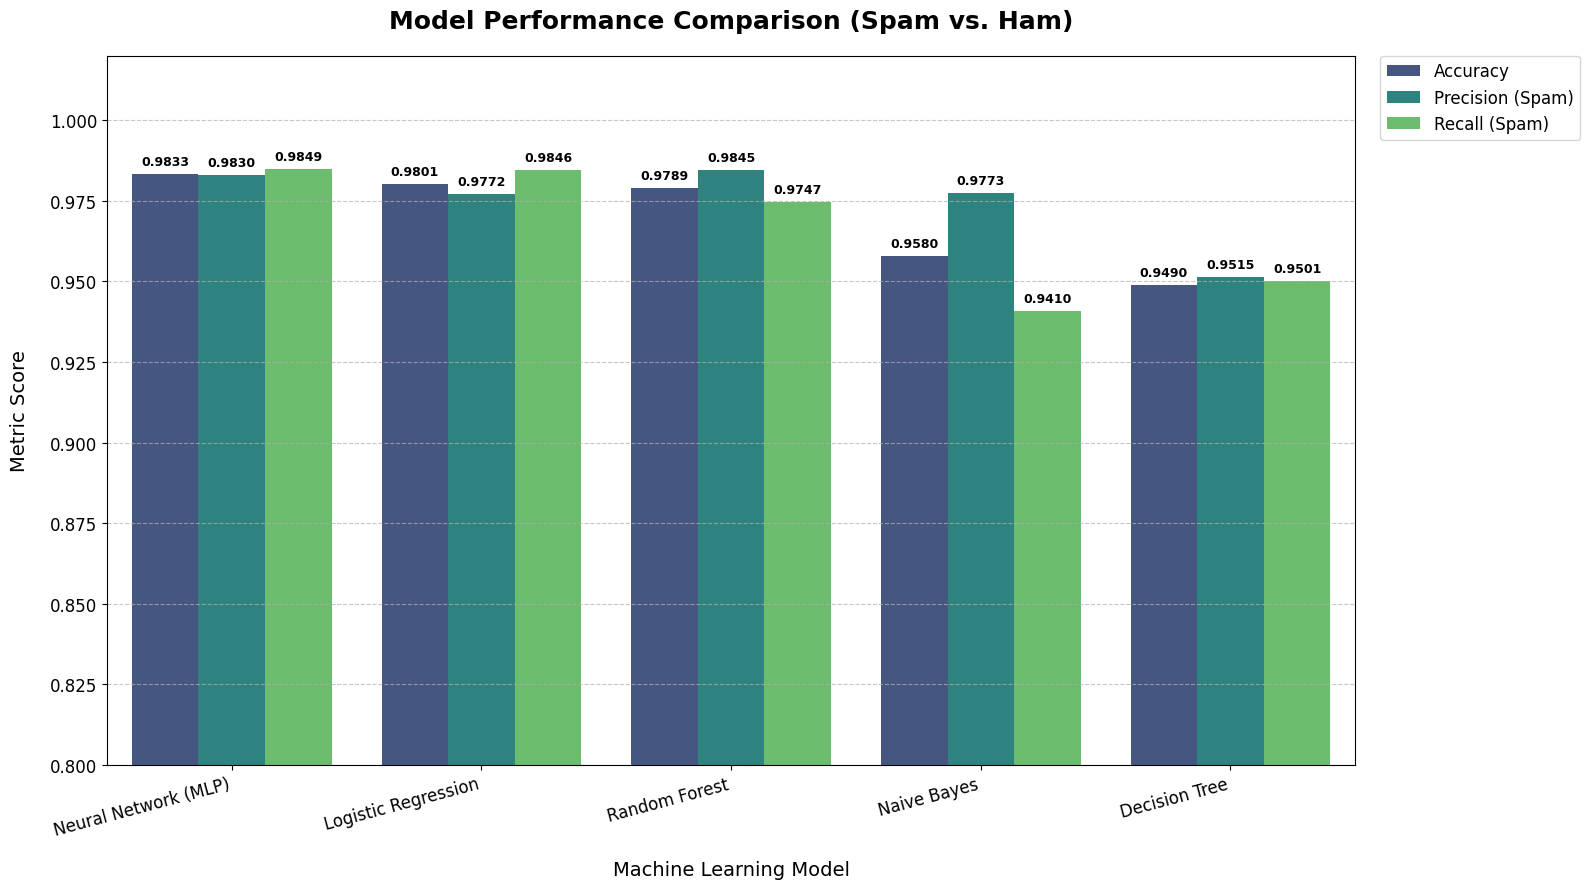

In [9]:
# --- Add this code to a new cell at the end of your notebook ---

import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Visualizing Model Results ---")

# 1. Prepare the data for plotting
# The 'results_df' is "wide" (one column per metric).
# We need to "melt" it into a "long" format for Seaborn.
# We also move the index (model names) into a regular column.

if 'results_df' in locals():
    plot_df = results_df.reset_index().rename(columns={'index': 'Model'})

    # Melt the DataFrame
    plot_df_long = plot_df.melt('Model', var_name='Metric', value_name='Score')

    print("Data prepared for plotting.")

    # 2. Create the grouped bar chart
    plt.figure(figsize=(16, 9))  # Set a larger figure size for readability

    # Use sns.barplot() to create the grouped plot
    # x='Model' -> Puts the model names on the X-axis
    # y='Score' -> The height of the bars
    # hue='Metric' -> Creates the groups (side-by-side bars) for each metric
    ax = sns.barplot(
        data=plot_df_long,
        x='Model',
        y='Score',
        hue='Metric',
        palette='viridis'  # Use a color-blind-friendly palette
    )

    # 3. Customize and polish the plot

    # Set titles and labels
    ax.set_title('Model Performance Comparison (Spam vs. Ham)', fontsize=18, weight='bold', pad=20)
    ax.set_xlabel('Machine Learning Model', fontsize=14, labelpad=15)
    ax.set_ylabel('Metric Score', fontsize=14, labelpad=15)

    # Set the Y-axis limit from 0.8 to 1.02 (or 0.0 to 1.02)
    # Since most scores are high, starting from a higher value (like 0.8)
    # can make the differences between models clearer.
    # If any model performs very poorly, change 0.8 to 0.0.
    min_score = plot_df_long['Score'].min()
    plot_min_y = 0.8 if min_score > 0.75 else 0.0

    ax.set_ylim(plot_min_y, 1.02)

    # Add a grid for easier reading
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Add the exact score values (annotations) on top of each bar
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.4f}',  # Format the number to 4 decimal places
            (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
            ha='center',
            va='center',
            xytext=(0, 9),  # Offset 9 points vertically
            textcoords='offset points',
            fontsize=9,
            weight='bold'
        )

    # Rotate X-axis labels for better fit
    plt.xticks(rotation=15, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    # Move the legend to the best location (usually 'upper right' or 'best')
    # Or place it outside the plot:
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=12)

    # Ensure everything fits
    plt.tight_layout()

    # Display the plot
    plt.show()

else:
    print("Could not find 'results_df'. Please run the model training and evaluation cell first.")

In [10]:
# Assuming 'pipe_lr' is your trained Logistic Regression pipeline
model = pipe_lr.named_steps['classifier']
vectorizer = pipe_lr.named_steps['tfidf']
feature_names = vectorizer.get_feature_names_out()

# Get the coefficients (weights)
coefs = model.coef_[0]

# Sort them to find the strongest signals
df_coeffs = pd.DataFrame({'word': feature_names, 'weight': coefs})
print("--- Top Phishing Triggers ---")
print(df_coeffs.sort_values(by='weight', ascending=False).head(10))

print("\n--- Top Benign Indicators ---")
print(df_coeffs.sort_values(by='weight', ascending=True).head(10))

--- Top Phishing Triggers ---
               word    weight
2439  josemonkeyorg  5.720161
2682           love  4.965849
2595           life  4.899593
33          account  4.872509
2079           http  4.164700
4856        watches  3.869263
2350     investment  3.759675
3767         remove  3.759519
748           click  3.723741
4273     statements  3.468936

--- Top Benign Indicators ---
            word     weight
1452       enron -11.042775
4961       wrote -10.010308
4504      thanks  -8.397404
3367          pm  -6.829289
4722         url  -6.041084
4802       vince  -5.751411
3120    opensuse  -5.680208
1067        date  -5.382397
2681      louise  -5.371470
4693  university  -5.265638


Calculating metrics for visualizations...


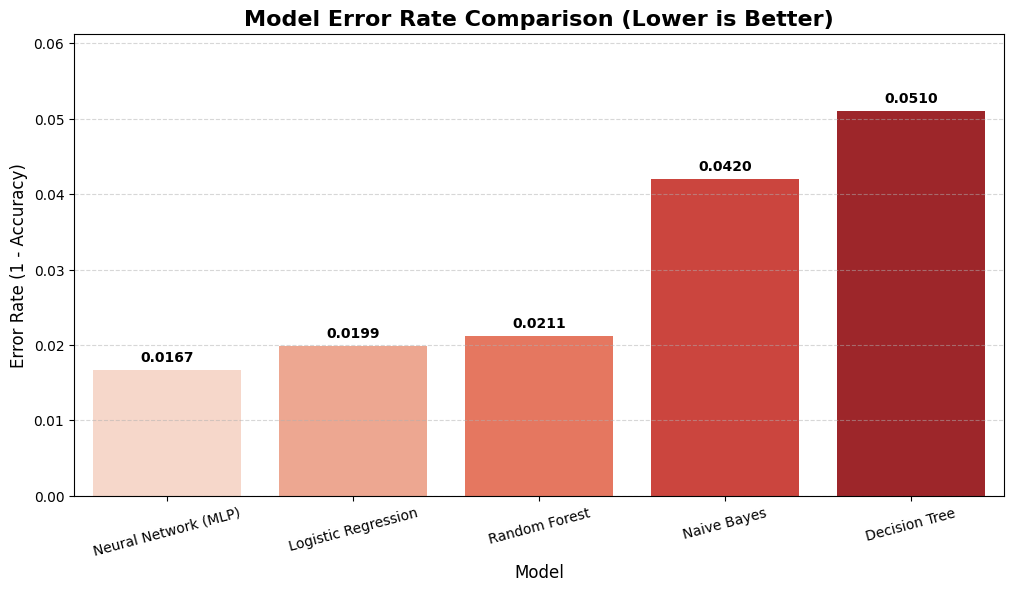

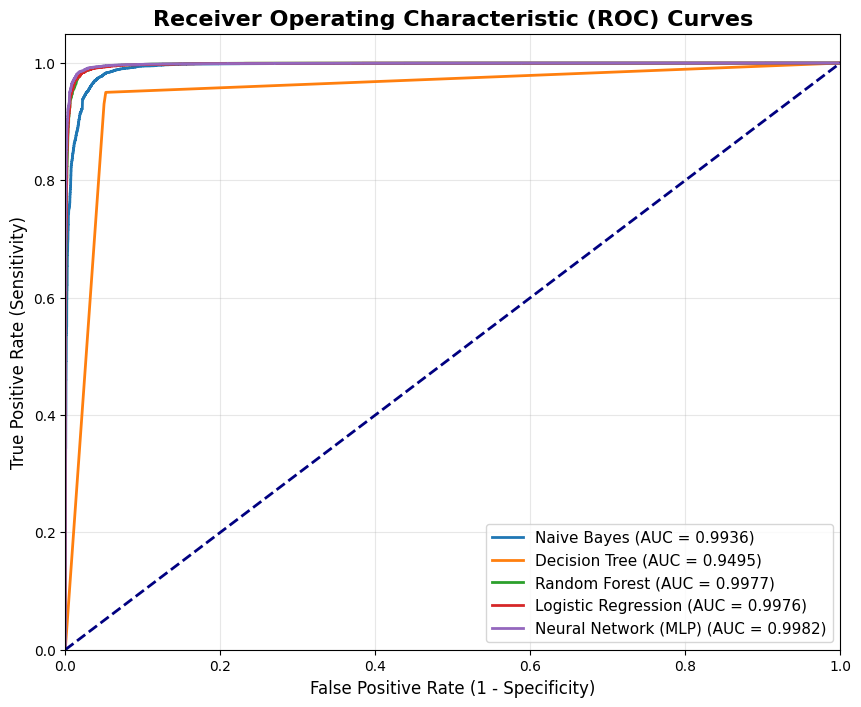

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score

# --- 1. Calculate Metrics (Error Rate & ROC) ---
model_metrics = []
roc_data = {}

print("Calculating metrics for visualizations...")

for name, model in models.items():
    # Predict hard classes for Error Rate
    y_pred = model.predict(X_test)
    error_rate = 1 - accuracy_score(y_test, y_pred)

    # Predict probabilities for ROC/AUC
    # Note: NB, RF, MLP, LR all support predict_proba.
    # DecisionTree supports it too (though often just 0/1, it works for the API).
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1] # Probability of class 1 (Spam)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        # Store for plotting
        roc_data[name] = {
            'fpr': fpr,
            'tpr': tpr,
            'auc': roc_auc
        }
    else:
        roc_auc = 0.0 # Fallback if model doesn't support probabilities

    model_metrics.append({
        'Model': name,
        'Error Rate': error_rate,
        'AUC': roc_auc
    })

metrics_df = pd.DataFrame(model_metrics).sort_values(by='Error Rate')

# --- 2. Plot Error Rate Diagram ---
plt.figure(figsize=(12, 6))
ax1 = sns.barplot(data=metrics_df, x='Model', y='Error Rate', palette='Reds')

plt.title('Model Error Rate Comparison (Lower is Better)', fontsize=16, weight='bold')
plt.ylabel('Error Rate (1 - Accuracy)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, max(metrics_df['Error Rate']) * 1.2) # Add some headroom

# Add values on top of bars
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.4f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 9), textcoords='offset points', weight='bold')

plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# --- 3. Plot ROC Curve (AUC) Diagram ---
plt.figure(figsize=(10, 8))

for name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], lw=2,
             label=f'{name} (AUC = {data["auc"]:.4f})')

# Plot diagonal line (random guessing)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16, weight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()